In [1]:
import pandas as pd
from sklearn.cluster import KMeans
from kneed import KneeLocator
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler
# Pipeline

In [2]:
data = pd.read_csv('application/dataset/gituserdata.csv', usecols=['username', 'content'])

In [3]:
data.head()

,username,content
0,esin,calathea shell dris docker remote image size ...
1,jeffersonsimaogoncalves,animacao icone app javascript
2,pedrualves,abc abc android angular translated rustic sim...
3,kroitor,asciichart nice looking lightweight console as...
4,vivekweb2013,audio recorder free simple audio recorder app ...


In [4]:
data.isna().sum()

username     0
content     37
dtype: int64

In [5]:
data.dropna(inplace=True)

In [6]:
data.reset_index(drop=True, inplace=True)

In [7]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
data.content = data.content.apply(lambda x: " ".join([word for word in x.split() if word not in stop_words]))

In [8]:
data.head()

,username,content
0,esin,calathea shell dris docker remote image size d...
1,jeffersonsimaogoncalves,animacao icone app javascript
2,pedrualves,abc abc android angular translated rustic simp...
3,kroitor,asciichart nice looking lightweight console as...
4,vivekweb2013,audio recorder free simple audio recorder app ...


In [9]:
from collections import Counter

count = Counter(data.content.iloc[0].split())

In [10]:
[x[0] for x in count.most_common(10)]

['shell',
 'go',
 'dockerfile',
 'html',
 'docker',
 'image',
 'dump1090',
 'exporter',
 'esin',
 'scripts']

In [11]:
data['most_common_skills'] = data.content.apply(lambda x: [t[0] for t in Counter(x.split()).most_common(10)])

In [12]:
data.head()

,username,content,most_common_skills
0,esin,calathea shell dris docker remote image size d...,"[shell, go, dockerfile, html, docker, image, d..."
1,jeffersonsimaogoncalves,animacao icone app javascript,"[animacao, icone, app, javascript]"
2,pedrualves,abc abc android angular translated rustic simp...,"[javascript, html, css, project, angularjs, ab..."
3,kroitor,asciichart nice looking lightweight console as...,"[c, python, javascript, html, docs, gjk, ascii..."
4,vivekweb2013,audio recorder free simple audio recorder app ...,"[android, java, javascript, go, audio, recorde..."


In [13]:
corpus = data.content.tolist()

vectorizer = TfidfVectorizer(max_features=5000)
scaler = StandardScaler(with_mean=False)

_ = vectorizer.fit(corpus)

vectors = vectorizer.transform(corpus)#.toarray()

scaled_features = scaler.fit_transform(vectors)


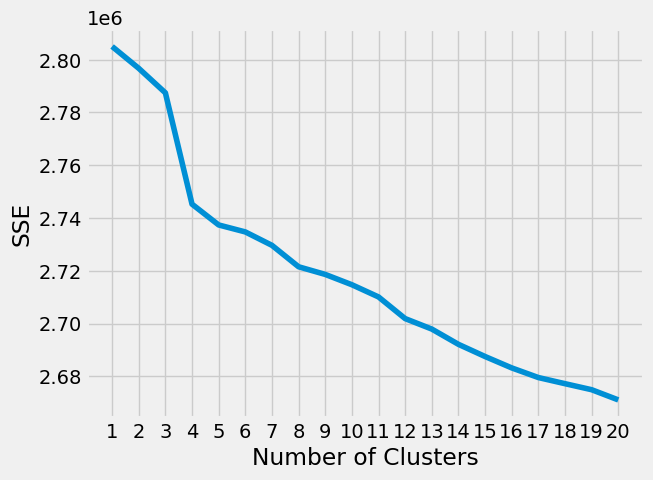

In [14]:
# Kmeans
kmeans_kwargs = {"init": "random", "n_init": 10, "max_iter": 300, "random_state": 42}

# A list holds the SSE values for each k
sse = []
for k in range(1, 21):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(scaled_features)
    sse.append(kmeans.inertia_)

plt.style.use("fivethirtyeight")
plt.plot(range(1, 21), sse)
plt.xticks(range(1, 21))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

In [15]:
kl = KneeLocator(range(1, 21), sse, curve="convex", direction="decreasing")

n_clusters = kl.elbow

In [16]:
n_clusters

8

In [17]:
dim_reducer = PCA(n_components=50)
scaled_reduced_features = scaled_features.toarray()#dim_reducer.fit_transform(scaled_features.toarray())

In [18]:
# Final model
kmeans_kwargs = {"init": "random", "n_init": 1, "max_iter": 300, "random_state": 42}
kmeans = KMeans(n_clusters=8, **kmeans_kwargs)

In [19]:
_ = kmeans.fit(scaled_reduced_features)

In [20]:
data['cluster']=kmeans.predict(scaled_reduced_features)

In [21]:
data.head()

,username,content,most_common_skills,cluster
0,esin,calathea shell dris docker remote image size d...,"[shell, go, dockerfile, html, docker, image, d...",4
1,jeffersonsimaogoncalves,animacao icone app javascript,"[animacao, icone, app, javascript]",4
2,pedrualves,abc abc android angular translated rustic simp...,"[javascript, html, css, project, angularjs, ab...",4
3,kroitor,asciichart nice looking lightweight console as...,"[c, python, javascript, html, docs, gjk, ascii...",4
4,vivekweb2013,audio recorder free simple audio recorder app ...,"[android, java, javascript, go, audio, recorde...",4


In [22]:
cleaned_user = data.content.iloc[134]
#cleaned_user = preprocessor(user)
vec_user = vectorizer.transform([cleaned_user])
scaled_user = scaler.transform(vec_user)
dim_user = scaled_user.toarray() #dim_reducer.transform(vec_user.toarray())
cluster = kmeans.predict(dim_user)[0]
cluster

4

In [23]:
cluster_df = data.loc[data.cluster == cluster]
indices = cluster_df.index.tolist()
cluster_reduced_features = scaled_reduced_features[indices]

In [24]:
cluster_df.reset_index(drop=True, inplace=True)

In [25]:
cluster_df.head()

,username,content,most_common_skills,cluster
0,esin,calathea shell dris docker remote image size d...,"[shell, go, dockerfile, html, docker, image, d...",4
1,jeffersonsimaogoncalves,animacao icone app javascript,"[animacao, icone, app, javascript]",4
2,pedrualves,abc abc android angular translated rustic simp...,"[javascript, html, css, project, angularjs, ab...",4
3,kroitor,asciichart nice looking lightweight console as...,"[c, python, javascript, html, docs, gjk, ascii...",4
4,vivekweb2013,audio recorder free simple audio recorder app ...,"[android, java, javascript, go, audio, recorde...",4


In [26]:
cluster_df.shape

(554, 4)

In [27]:
knn = NearestNeighbors(n_neighbors=10, algorithm='brute', metric='euclidean')
_ = knn.fit(cluster_reduced_features)
dists, idx = knn.kneighbors(dim_user)

In [28]:
cluster_df.iloc[idx[0]]

,username,content,most_common_skills,cluster
133,philcryer,art philcryer com source code art site running...,"[shell, html, css, javascript, script, url, gi...",4
115,GAGATRACK,fsts audiovisual notch,"[fsts, audiovisual, notch]",4
423,hgcsoft,embarcadero,[embarcadero],4
420,melihcanmavis,signinwithapple swift,"[signinwithapple, swift]",4
307,TaniraWrites,brooklyncommunityboard swift,"[brooklyncommunityboard, swift]",4
326,arb1nsnmgl,hugecodechallengeflatiron swift inbetwin inbet...,"[swift, hugecodechallengeflatiron, inbetwin, i...",4
414,ggnull35,i40e dkms shell,"[i40e, dkms, shell]",4
514,dylaw,battah github io css html javascript php,"[battah, github, io, css, html, javascript, php]",4
405,fethan,fethan github io html,"[fethan, github, io, html]",4
1,jeffersonsimaogoncalves,animacao icone app javascript,"[animacao, icone, app, javascript]",4


In [29]:
data.iloc[[134]]

,username,content,most_common_skills,cluster
134,philcryer,art philcryer com source code art site running...,"[shell, html, css, javascript, script, url, gi...",4


In [30]:
from scipy.spatial.distance import euclidean

In [31]:
dim_user

array([[0., 0., 0., ..., 0., 0., 0.]])

In [32]:
euclidean(dim_user[0], scaled_reduced_features[134])

0.0

In [33]:
sum(scaled_reduced_features[134])

1164.7042595278594

In [34]:
sum(dim_user[0])

1164.7042595278594